# Fluid-Structure Interaction using `Dyn3d` and `Whirl`

## <span style="color:blue"> Include Packages

In [1]:
using Pkg
Pkg.activate("..")

using Revise
using Dyn3d
using FSI

┌ Info: Recompiling stale cache file /home/fs/.julia/compiled/v1.0/FSI/t27zx.ji for FSI [39fdbc7a-862a-11e9-015b-61723af7393f]
└ @ Base loading.jl:1190


In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [42]:
# problem dimension
ndim = 2
# numerical params
tf = 6
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., -1.0, 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 1
config_body = ConfigBody(nbody, 4,
   [0. 0.; 1. 0.; 1. 1.0/nbody; 0. 1.0/nbody], 2.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody

config_joints = Vector{ConfigJoint}(undef,njoint)

# set the first passive joint with no stiff and damp
dof_1 = Dof(5, "passive", 0., 0., Motions())

config_joints[1] = ConfigJoint(njoint, "custom_prismatic_in_y",
    [0.,0.,0.,0.5,2.0,0.], zeros(Float64,6), 0, [dof_1], [0.])

 joint type = custom_prismatic_in_y
 joint position in parent body coord = [0.0, 0.0, 0.0, 0.5, 2.0, 0.0]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 5, under passive motion
 initial unconstrained dof position = [0.0]


#### Build joint-body chain

In [43]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 1 body-joint system, system is un-mounted from space

#### Initialize rigid body system state

In [44]:
# initialize system to complete body-joint information
bd, soln = InitSystem!(bd)

# initialize solution structure
solns = (Soln)[]
push!(solns, soln);

#### Get body verts for plotting

In [45]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, solns[1].qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

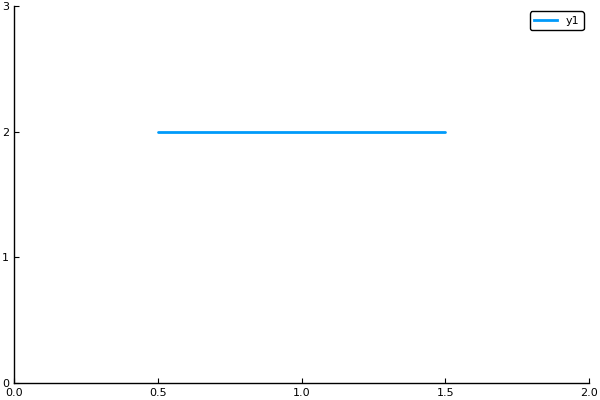

In [46]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
end
plot!(xlims=(0,2), ylims=(0,3))

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [47]:
Re = 200 # Reynolds number
U = 0.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, 0.0)

#### Set the domain grid and time step size

In [48]:
nx = 102; ny = 152;
Ly = 3.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:2.0100000000000002, -0.01:0.02:3.0100000000000002)

#### Set up initial conditions

In [49]:
t = 0.0
tf = 200*Δt
T = Δt:Δt:tf

w₀ .= 0.0
fx = Float64[]
fy = Float64[]
thist = []
uhist = []
bdhist = []
tsample = 0.02;
Δt

0.01

## <span style="color:blue"> Create fluid-body interface </span>

#### Genrate body grid points and get linear velocity on them

In [50]:
# bgs short for body grid system
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx));
bgs = CutOut2d(bd,bgs);
bgs = AcquireBodyGridKinematics(bd,bgs)

coord = hcat(bgs[1].q_i...)'[:,[1,2]]
motion = hcat(bgs[1].v_i...)'[:,[1,2]]
for i = 2:length(bgs)
    coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
    motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,2]]]
end

#### Variable containers for all stages in IFHERK and HERKBody

In [51]:
# Herk stages for both body and fluid solver
NS = bd.sys.num_params.st
if NS != 3 error("Dyn3d RK scheme not the same with Whirl") end

# Body kinematics container for ifherk input and herkbody output
bkins = Vector{Array{Float64,2}}(undef,NS)

# Body force container for ifherk output(not integrated)
fs = Vector{Array{Float64,2}}(undef,NS)

# Body force container for herkbody input(integrated)
f_exis = [zeros(bd.sys.nbody,6) for i=1:NS]

# All body info container
bds = [bd for i=1:NS];

#### Get body points initial coordinates for fluids

In [52]:
bgs = AcquireBodyGridKinematics(bd,bgs)
coord = hcat(bgs[1].q_i...)'[:,[1,2]]
for i = 2:length(bgs)
    coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
end
coord_init = coord;

## <span style="color:blue"> Set up integrators for Time Marching </span>

#### Set up the Navier-Stokes  problem type

In [53]:
X̃ = VectorData(coord_init)
fsys = FSI.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, isstore = true, isstatic = false)

Navier-Stokes system on a grid of size 102 x 152

#### Constants for coupling

In [54]:
tol = 5e-4  # coupling tolerance
ω = (config_bodys[1].ρ)/(1.0+config_bodys[1].ρ)  # relaxation parameter

0.6666666666666666

#### Create Body solver object of type HerkBody

In [55]:
herkbody = Dyn3d.HERKBody(bd.sys.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
            ((bs,js,sys,f_exi) -> HERKFuncf(bs,js,sys,f_exi,"cylinder",config_body.ρ),HERKFuncgti),
            (UpdatePosition!,UpdateVelocity!))

Order-3 HERK time-marching function like object for Dyn3d


#### Create Fluid solver object of type IFHERK

In [56]:
u = w₀
f = VectorData(X̃)
fs = [[f.u f.v] for i=1:NS]

# construct fluid solver with uniform constant free stream
ifherk_sc2d = FSI.IFHERK_sc2d(u,f,fsys.Δt,
                (t,u) -> FSI.Systems.plan_intfact(t,u,fsys),
                (u,t,coord) -> FSI.plan_constraints(u,t,fsys,coord),
                ((u,t) -> FSI.r₁(u,t,fsys),
                 (u,t,motion) -> FSI.r₂(u,t,fsys,motion)),
                coord_init,
                tol=1e-3,rk=FSI.TimeMarching.RK31,
                isstored=true,isstaticconstraints=false)

Order-3 IF-HERK for fs interaction integrator with
   State of type Nodes{Dual,102,152}
   Force of type VectorData{51}
   Time step size 0.01


## <span style="color:blue"> Time Marching! </span>

#### Make timestep in Dyn3d the same with Whirl

In [57]:
soln.dt = Δt
solns[1].dt = soln.dt

# total number of body points in the fluid solver
np_total = round(Int,length(f)/2)

51

#### Proceed with normal coupling AFTER the first timestep

In [58]:
@time for ti in T
@time begin
    iter = 1
    fᵢ = fs.*Δx^2

    # record body info
    soln_buffer = deepcopy(soln)
    global bd
    bd_buffer = deepcopy(bd)
    bgs_buffer = deepcopy(bgs)

    # record fluid info
    u_buffer = deepcopy(u)
    t_buffer = t

    # interation until coupled
    while true

        #--------------------------------------------------------
        # get body state of the last timestep
        soln = deepcopy(soln_buffer)
        bd = deepcopy(bd_buffer)
        bgs = deepcopy(bgs_buffer)

        #--------------------------------------------------------
        # integrate body forces from body points
        for k = 1:NS
            b_cnt = 1
            ref = 0
            for i = 1:np_total
                # move to the next bgs if i exceed bgs[b_cnt].np
                if i > ref + bgs[b_cnt].np
                    ref += bgs[b_cnt].np
                    b_cnt += 1        
                end
                bgs[b_cnt].f_ex3d[i-ref][[1,2]] = fᵢ[k][i,:]
            end

            # integrate total forces from all body points on a body
            bgs = IntegrateBodyGridDynamics(bd,bgs)
            for i = 1:bd.sys.nbody
                f_exis[k][i,:] = bgs[i].f_ex6d
            end
        end
        
        #--------------------------------------------------------
        # advance body solver for one step        
        global soln, bds = herkbody(soln, bd; _isfixedstep=true, _outputmode=true, f_exi=f_exis);

        #--------------------------------------------------------
        # acquire coord and motion(velocity) of body points for fluid computation
        for k = 1:NS
            bgs = AcquireBodyGridKinematics(bds[k],bgs)
            coord = hcat(bgs[1].q_i...)'[:,[1,2]]
            motion = hcat(bgs[1].v_i...)'[:,[1,2]]
            for i = 2:length(bgs)
                coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
                motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,2]]]
            end
            bkins[k] = [coord motion]
        end
        
        #--------------------------------------------------------
        # get fluid state of the last timestep
        u = deepcopy(u_buffer)
        t = t_buffer

        #--------------------------------------------------------
        # advance fluid solver for one step
        global t, u, f, fs = ifherk_sc2d(t,u,bkins)

        #--------------------------------------------------------
        # check if converge, use relaxation if not
        ϵ = abs(sum(fs[NS]*Δx^2 - fᵢ[NS]))
        if ϵ < tol break end

#         println("proposed fy at last stage: ", sum(fᵢ[NS][:,2]))
#         println("corrected fy at last stage: ", sum(fs[NS][:,2])*Δx^2)
        
        # if not converge, use relaxation
        fᵢ = (1-ω)*fᵢ + ω*fs*Δx^2
        
#         println("relaxation fy at last stage: ", sum(fᵢ[NS][:,2]),"\n")
#         println("iteration ",iter,", ϵ = ",ϵ)
        iter += 1   
        
    end
    
    # converged for this timestep
    print("time = ", t-Δt, " converged through ", iter, " iterations\n")
    
    # record converged bd for next step
    bd = bds[NS]
    
    # record body solution for this timestep
    push!(solns, soln)

    # record fluid solution for this timestep
    push!(thist,t)
    push!(bdhist,deepcopy(bd))
    push!(fx,sum(fᵢ[NS][:,1]))
    push!(fy,sum(fᵢ[NS][:,2]))
    push!(uhist,deepcopy(u))
end
end

proposed fy at last stage: 0.0
corrected fy at last stage: 0.9774301544839308
relaxation fy at last stage: 0.6516201029892871

iteration 1, ϵ = 0.9774301544839307
proposed fy at last stage: 0.6516201029892871
corrected fy at last stage: 0.8013913887336302
relaxation fy at last stage: 0.7514676268188492

iteration 2, ϵ = 0.14977128574434317
proposed fy at last stage: 0.7514676268188492
corrected fy at last stage: 0.7964661504377634
relaxation fy at last stage: 0.7814666425647918

iteration 3, ϵ = 0.044998523618914085
proposed fy at last stage: 0.7814666425647918
corrected fy at last stage: 0.7963283515000911
relaxation fy at last stage: 0.7913744485216581

iteration 4, ϵ = 0.014861708935299136
proposed fy at last stage: 0.7913744485216581
corrected fy at last stage: 0.7963244961755118
relaxation fy at last stage: 0.7946744802908938

iteration 5, ϵ = 0.004950047653853818
proposed fy at last stage: 0.7946744802908938
corrected fy at last stage: 0.7963243883152851
relaxation fy at last sta

time = 0.09999999999999999 converged through 4 iterations
 12.689010 seconds (113.06 M allocations: 3.656 GiB, 6.69% gc time)
proposed fy at last stage: 0.8029548231579169
corrected fy at last stage: 0.8059059681538586
relaxation fy at last stage: 0.8049222531552115

iteration 1, ϵ = 0.0029511449959420625
proposed fy at last stage: 0.8049222531552115
corrected fy at last stage: 0.8040441970156813
relaxation fy at last stage: 0.8043368823955247

iteration 2, ϵ = 0.0008780561395300113
proposed fy at last stage: 0.8043368823955247
corrected fy at last stage: 0.8037614300951299
relaxation fy at last stage: 0.8039532475285948

iteration 3, ϵ = 0.0005754523003947215
time = 0.10999999999999999 converged through 4 iterations
 12.815658 seconds (113.06 M allocations: 3.656 GiB, 5.85% gc time)
proposed fy at last stage: 0.8036764951262171
corrected fy at last stage: 0.80653160581703
relaxation fy at last stage: 0.8055799022534258

iteration 1, ϵ = 0.0028551106908133272
proposed fy at last stage:

time = 0.26000000000000006 converged through 3 iterations
  9.697610 seconds (84.79 M allocations: 2.742 GiB, 6.93% gc time)
proposed fy at last stage: 0.8108443689528418
corrected fy at last stage: 0.8117131746876795
relaxation fy at last stage: 0.8114235727760669

iteration 1, ϵ = 0.0008688057348393321
proposed fy at last stage: 0.8114235727760669
corrected fy at last stage: 0.8108074745793753
relaxation fy at last stage: 0.8110128406449392

iteration 2, ϵ = 0.0006160981966912631
time = 0.2700000000000001 converged through 3 iterations
  9.552142 seconds (84.79 M allocations: 2.742 GiB, 5.92% gc time)
proposed fy at last stage: 0.8106549043813865
corrected fy at last stage: 0.8113296988194946
relaxation fy at last stage: 0.8111047673401254

iteration 1, ϵ = 0.0006747944381086669
proposed fy at last stage: 0.8111047673401254
corrected fy at last stage: 0.8104721756064581
relaxation fy at last stage: 0.8106830395176806

iteration 2, ϵ = 0.0006325917336676636
time = 0.2800000000000001 c

time = 0.47000000000000025 converged through 3 iterations
  9.443365 seconds (84.79 M allocations: 2.742 GiB, 5.84% gc time)
proposed fy at last stage: 0.812475826377518
corrected fy at last stage: 0.8118560923944682
relaxation fy at last stage: 0.8120626703888181

iteration 1, ϵ = 0.0006197339830510389
proposed fy at last stage: 0.8120626703888181
corrected fy at last stage: 0.8113057962318155
relaxation fy at last stage: 0.811558087617483

iteration 2, ϵ = 0.0007568741570035131
time = 0.48000000000000026 converged through 3 iterations
  9.558036 seconds (84.79 M allocations: 2.742 GiB, 5.83% gc time)
proposed fy at last stage: 0.8111853855524271
corrected fy at last stage: 0.8145741792074594
relaxation fy at last stage: 0.8134445813224489

iteration 1, ϵ = 0.0033887936550345
time = 0.4900000000000002 converged through 2 iterations
  6.451022 seconds (56.53 M allocations: 1.828 GiB, 5.91% gc time)
proposed fy at last stage: 0.8130246421756943
corrected fy at last stage: 0.824644794220

proposed fy at last stage: 0.834476943366174
corrected fy at last stage: 0.8337120190669539
relaxation fy at last stage: 0.8339669938333605

iteration 2, ϵ = 0.0007649242992212131
time = 0.6600000000000004 converged through 3 iterations
  9.465077 seconds (84.79 M allocations: 2.742 GiB, 5.87% gc time)
proposed fy at last stage: 0.83357696925163
corrected fy at last stage: 0.8281957963282758
relaxation fy at last stage: 0.8299895206360605

iteration 1, ϵ = 0.005381172923356721
proposed fy at last stage: 0.8299895206360605
corrected fy at last stage: 0.8287965547044592
relaxation fy at last stage: 0.8291942100149929

iteration 2, ϵ = 0.0011929659316006053
time = 0.6700000000000004 converged through 3 iterations
  9.460135 seconds (84.79 M allocations: 2.742 GiB, 5.90% gc time)
proposed fy at last stage: 0.8287366120889006
corrected fy at last stage: 0.8228223897924838
relaxation fy at last stage: 0.8247937972246226

iteration 1, ϵ = 0.005914222296414873
proposed fy at last stage: 0.8247

proposed fy at last stage: 0.8508427133453612
corrected fy at last stage: 0.8499590237980238
relaxation fy at last stage: 0.8502535869804695

iteration 2, ϵ = 0.0008836895473370739
time = 0.8300000000000005 converged through 3 iterations
  9.396031 seconds (84.79 M allocations: 2.742 GiB, 5.95% gc time)
proposed fy at last stage: 0.8497678204775416
corrected fy at last stage: 0.8390375546546364
relaxation fy at last stage: 0.842614309928938

iteration 1, ϵ = 0.010730265822905774
proposed fy at last stage: 0.842614309928938
corrected fy at last stage: 0.8405886163106309
relaxation fy at last stage: 0.8412638475167333

iteration 2, ϵ = 0.0020256936183066106
proposed fy at last stage: 0.8412638475167333
corrected fy at last stage: 0.8405322848127377
relaxation fy at last stage: 0.8407761390474028

iteration 3, ϵ = 0.0007315627039962052
time = 0.8400000000000005 converged through 4 iterations
 12.544993 seconds (113.06 M allocations: 3.656 GiB, 5.92% gc time)
proposed fy at last stage: 0.8

proposed fy at last stage: 0.8680701719214327
corrected fy at last stage: 0.8674069499624528
relaxation fy at last stage: 0.8676280239487794

iteration 3, ϵ = 0.0006632219589792245
time = 0.9700000000000006 converged through 4 iterations
 13.308003 seconds (113.06 M allocations: 3.656 GiB, 6.07% gc time)
proposed fy at last stage: 0.8673291047236392
corrected fy at last stage: 0.8550526857315092
relaxation fy at last stage: 0.8591448253955524

iteration 1, ϵ = 0.012276418992131617
proposed fy at last stage: 0.8591448253955524
corrected fy at last stage: 0.8568371016142681
relaxation fy at last stage: 0.8576063428746963

iteration 2, ϵ = 0.002307723781284866
proposed fy at last stage: 0.8576063428746963
corrected fy at last stage: 0.856728025494805
relaxation fy at last stage: 0.8570207979547687

iteration 3, ϵ = 0.0008783173798925084
time = 0.9800000000000006 converged through 4 iterations
 12.906499 seconds (113.06 M allocations: 3.656 GiB, 5.98% gc time)
proposed fy at last stage: 0.

time = 1.1000000000000008 converged through 4 iterations
 13.427543 seconds (114.20 M allocations: 3.711 GiB, 5.81% gc time)
proposed fy at last stage: 0.8819689174836857
corrected fy at last stage: 0.8596000025387497
relaxation fy at last stage: 0.8670563075203951

iteration 1, ϵ = 0.022368914944933725
proposed fy at last stage: 0.8670563075203951
corrected fy at last stage: 0.8632937088383051
relaxation fy at last stage: 0.8645479083990019

iteration 2, ϵ = 0.003762598682090426
proposed fy at last stage: 0.8645479083990019
corrected fy at last stage: 0.8632473153695588
relaxation fy at last stage: 0.863680846379373

iteration 3, ϵ = 0.0013005930294421734
time = 1.1100000000000008 converged through 4 iterations
 12.715317 seconds (113.06 M allocations: 3.656 GiB, 5.91% gc time)
proposed fy at last stage: 0.8631971099482498
corrected fy at last stage: 0.8385986162745187
relaxation fy at last stage: 0.8467981141657623

iteration 1, ϵ = 0.02459849367373387
proposed fy at last stage: 0.84

proposed fy at last stage: 0.8632303638388069
corrected fy at last stage: 0.8618214499623541
relaxation fy at last stage: 0.8622910879211715

iteration 3, ϵ = 0.001408913876452164
time = 1.2300000000000009 converged through 4 iterations
 12.631208 seconds (113.06 M allocations: 3.656 GiB, 6.03% gc time)
proposed fy at last stage: 0.8618067834832351
corrected fy at last stage: 0.8403276319837646
relaxation fy at last stage: 0.8474873491502548

iteration 1, ϵ = 0.02147915149946892
proposed fy at last stage: 0.8474873491502548
corrected fy at last stage: 0.8425025332100965
relaxation fy at last stage: 0.8441641385234825

iteration 2, ϵ = 0.004984815940156798
proposed fy at last stage: 0.8441641385234825
corrected fy at last stage: 0.842475345714936
relaxation fy at last stage: 0.8430382766511182

iteration 3, ϵ = 0.0016887928085463054
proposed fy at last stage: 0.8430382766511182
corrected fy at last stage: 0.8424453990832844
relaxation fy at last stage: 0.842643024939229

iteration 4, ϵ 

proposed fy at last stage: 0.8587863334926521
corrected fy at last stage: 0.8582283258083155
relaxation fy at last stage: 0.8584143283697612

iteration 4, ϵ = 0.0005580076843370949
time = 1.340000000000001 converged through 5 iterations
 15.681800 seconds (141.32 M allocations: 4.570 GiB, 5.85% gc time)
proposed fy at last stage: 0.8582253210941667
corrected fy at last stage: 0.8797628759350279
relaxation fy at last stage: 0.872583690988074

iteration 1, ϵ = 0.021537554840858283
time = 1.350000000000001 converged through 2 iterations
  6.311873 seconds (56.53 M allocations: 1.828 GiB, 5.94% gc time)
proposed fy at last stage: 0.8723009917624882
corrected fy at last stage: 0.9223432470375243
relaxation fy at last stage: 0.905662495279179

iteration 1, ϵ = 0.05004225527503166
proposed fy at last stage: 0.905662495279179
corrected fy at last stage: 0.9131230258086377
relaxation fy at last stage: 0.9106361822988179

iteration 2, ϵ = 0.0074605305294578135
proposed fy at last stage: 0.910636

proposed fy at last stage: 0.9215139302572246
corrected fy at last stage: 0.9273678066026844
relaxation fy at last stage: 0.9254165144875311

iteration 2, ϵ = 0.0058538763454587025
proposed fy at last stage: 0.9254165144875311
corrected fy at last stage: 0.9268732129429657
relaxation fy at last stage: 0.9263876467911542

iteration 3, ϵ = 0.0014566984554330873
time = 1.460000000000001 converged through 4 iterations
 12.641493 seconds (113.06 M allocations: 3.656 GiB, 5.89% gc time)
proposed fy at last stage: 0.9267680174863956
corrected fy at last stage: 0.9376852925907406
relaxation fy at last stage: 0.9340462008892924

iteration 1, ϵ = 0.01091727510434973
proposed fy at last stage: 0.9340462008892924
corrected fy at last stage: 0.9333778097507777
relaxation fy at last stage: 0.9336006067969493

iteration 2, ϵ = 0.0006683911385107896
proposed fy at last stage: 0.9336006067969493
corrected fy at last stage: 0.9329982674542551
relaxation fy at last stage: 0.9331990472351531

iteration 3,

proposed fy at last stage: 0.9179223986971656
corrected fy at last stage: 0.9172481794322769
relaxation fy at last stage: 0.9174729191872397

iteration 4, ϵ = 0.0006742192648894234
time = 1.5700000000000012 converged through 5 iterations
 15.342701 seconds (141.32 M allocations: 4.570 GiB, 6.47% gc time)
proposed fy at last stage: 0.917222368200272
corrected fy at last stage: 0.8615934938332181
relaxation fy at last stage: 0.8801364519555694

iteration 1, ϵ = 0.05562887436706386
proposed fy at last stage: 0.8801364519555694
corrected fy at last stage: 0.8721439881225476
relaxation fy at last stage: 0.8748081427335548

iteration 2, ϵ = 0.007992463833025903
proposed fy at last stage: 0.8748081427335548
corrected fy at last stage: 0.8723945122977937
relaxation fy at last stage: 0.8731990557763807

iteration 3, ϵ = 0.002413630435761367
proposed fy at last stage: 0.8731990557763807
corrected fy at last stage: 0.8723867676950339
relaxation fy at last stage: 0.8726575303888162

iteration 4, ϵ

time = 1.6900000000000013 converged through 3 iterations
  9.246813 seconds (84.79 M allocations: 2.742 GiB, 5.91% gc time)
proposed fy at last stage: 0.9625447627503587
corrected fy at last stage: 0.9333589050631352
relaxation fy at last stage: 0.9430875242922098

iteration 1, ϵ = 0.029185857687226386
proposed fy at last stage: 0.9430875242922098
corrected fy at last stage: 0.9387096772746751
relaxation fy at last stage: 0.9401689596138534

iteration 2, ϵ = 0.004377847017535226
proposed fy at last stage: 0.9401689596138534
corrected fy at last stage: 0.9386400008249665
relaxation fy at last stage: 0.9391496537545956

iteration 3, ϵ = 0.001528958788888209
proposed fy at last stage: 0.9391496537545956
corrected fy at last stage: 0.9385664092037558
relaxation fy at last stage: 0.9387608240540357

iteration 4, ϵ = 0.0005832445508394288
time = 1.7000000000000013 converged through 5 iterations
 15.177045 seconds (141.32 M allocations: 4.570 GiB, 5.91% gc time)
proposed fy at last stage: 0.9

proposed fy at last stage: 0.8995346145362644
corrected fy at last stage: 0.8986825949385772
relaxation fy at last stage: 0.8989666014711396

iteration 4, ϵ = 0.0008520195976886916
time = 1.8000000000000014 converged through 5 iterations
 15.335406 seconds (141.32 M allocations: 4.570 GiB, 6.61% gc time)
proposed fy at last stage: 0.8986626897575071
corrected fy at last stage: 0.9842542743813684
relaxation fy at last stage: 0.9557237461734146

iteration 1, ϵ = 0.08559158462386625
proposed fy at last stage: 0.9557237461734146
corrected fy at last stage: 0.9697846440561573
relaxation fy at last stage: 0.965097678095243

iteration 2, ϵ = 0.014060897882746427
proposed fy at last stage: 0.965097678095243
corrected fy at last stage: 0.9691315997483994
relaxation fy at last stage: 0.9677869591973473

iteration 3, ϵ = 0.004033921653155753
proposed fy at last stage: 0.9677869591973473
corrected fy at last stage: 0.9690248998194866
relaxation fy at last stage: 0.9686122529454402

iteration 4, ϵ 

proposed fy at last stage: 0.9127890003770781
corrected fy at last stage: 0.9103108788170563
relaxation fy at last stage: 0.9111369193370635

iteration 3, ϵ = 0.002478121560020334
proposed fy at last stage: 0.9111369193370635
corrected fy at last stage: 0.9102455040960878
relaxation fy at last stage: 0.9105426425097464

iteration 4, ϵ = 0.0008914152409741474
time = 1.9200000000000015 converged through 5 iterations
 15.661877 seconds (141.32 M allocations: 4.570 GiB, 6.59% gc time)
proposed fy at last stage: 0.9102244109500993
corrected fy at last stage: 0.999487843313393
relaxation fy at last stage: 0.9697333658589617

iteration 1, ϵ = 0.08926343236328076
proposed fy at last stage: 0.9697333658589617
corrected fy at last stage: 0.9844032965958597
relaxation fy at last stage: 0.9795133196835605

iteration 2, ϵ = 0.014669930736893273
proposed fy at last stage: 0.9795133196835605
corrected fy at last stage: 0.9837426253654745
relaxation fy at last stage: 0.9823328568048366

iteration 3, ϵ

## <span style="color:blue"> Plot </span>

#### Set contour levels and gif name

In [59]:
contour_levels = range(-0.2,stop=0.2,length=30)
gif_name = "template_test.gif"
fps = 20;

#### Get body verts history

In [60]:
@get bd (bs, js, sys)
vshist = []
for i = 1:length(solns)
    bs, js, sys = UpdatePosition!(bs, js, sys, solns[i].qJ)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

#### Plot first and last time field

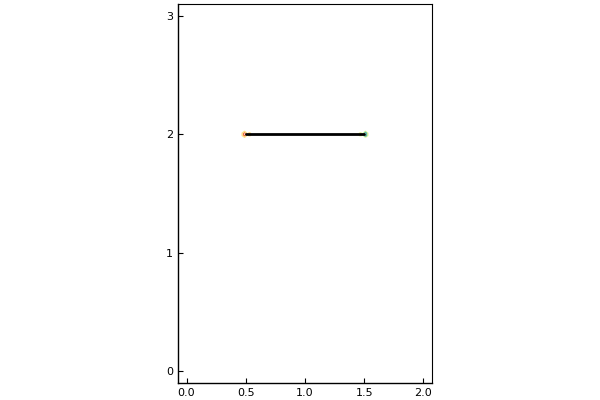

In [61]:
p1 = plot(xg,yg,uhist[1],levels=contour_levels)
for i = 1:sys.nbody
    plot!(p1,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black")
end
p1

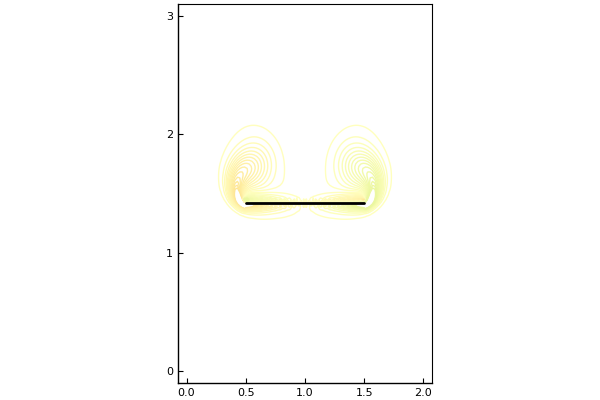

In [62]:
p2 = plot(xg,yg,uhist[end],levels=contour_levels)
for i = 1:sys.nbody
    plot!(p2,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="black")
end
p2

#### Body position at t=0 and t=tf

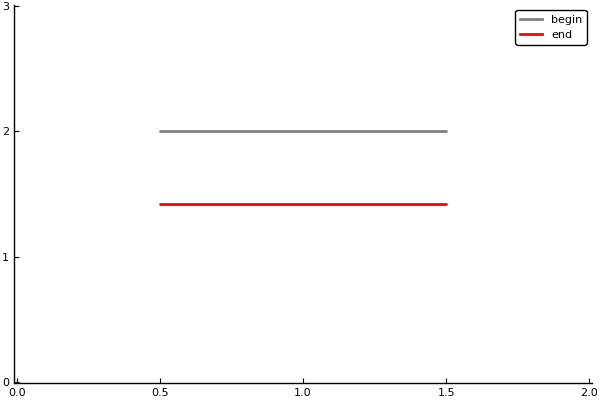

In [63]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="grey",label="begin")
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="red",label="end")
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]))
pb

#### Make a gif

In [64]:
# anim = @animate for j = 1:length(uhist)
#     plot(xg,yg,uhist[j],levels=contour_levels)
#     for i = 1:sys.nbody
#         plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="grey")
#     end
# end

# gif(anim, "movies/"*gif_name, fps = fps)

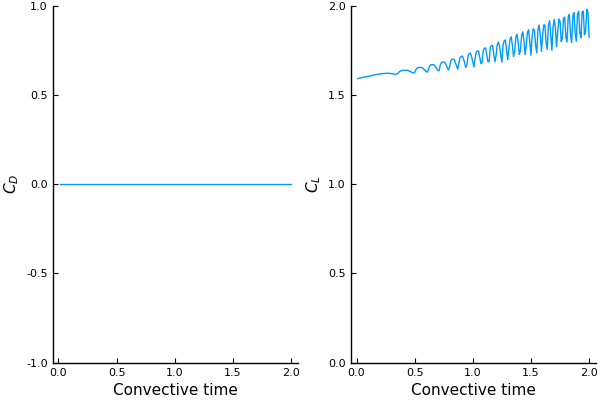

In [65]:
px = plot(thist,2*fx,ylim=(-1,1),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(0,2),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

In [66]:
vhist = [0.0]
phist = [0.0]

for i in 1:length(bdhist)
    push!(vhist,bdhist[i].bs[1].v[5])
    push!(phist,bdhist[i].bs[1].x_i[2]-bdhist[1].bs[1].x_i[2])    
end

ahist = []
for i in 1:length(vhist)-1
    push!(ahist,(vhist[i+1]-vhist[i])/Δt)
end

In [67]:
ahist

200-element Array{Any,1}:
 -0.3440793223322793 
 -0.34173574270438084
 -0.3397278894502954 
 -0.3379676614594391 
 -0.3363948915791781 
 -0.3349658911787862 
 -0.33365052635466774
 -0.33242640373334076
 -0.3312770066455712 
 -0.3301900637690709 
 -0.3291564222364977 
 -0.32816925409092434
 -0.3272234878302103 
  ⋮                  
 -0.1884459468926014 
 -0.17539570593561038
 -0.1726542788591301 
 -0.18633887392819348
 -0.18360300482487268
 -0.17108663186554685
 -0.1696575432177938 
 -0.18458667490830472
 -0.17755516669778482
 -0.16620632287521753
 -0.16805800996536613
 -0.1837256345505578 

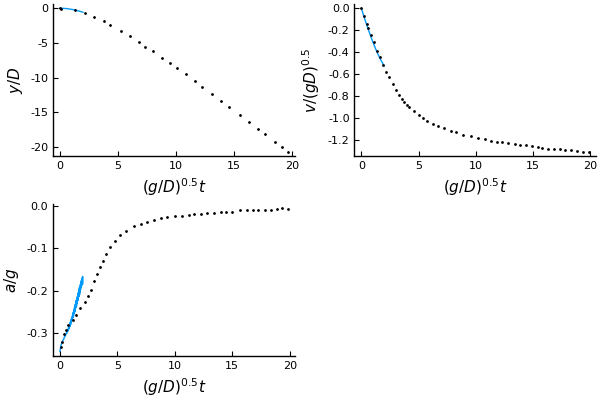

In [68]:
using CSV

pdata = CSV.read("local_run/validation/csv/position.csv",header=false)
xp = [pdata[i,1] for i in 1:length(pdata[1])]
yp = [pdata[i,2] for i in 1:length(pdata[2])]

vdata = CSV.read("local_run/validation/csv/velocity.csv",header=false)
xv = [vdata[i,1] for i in 1:length(vdata[1])]
yv = [vdata[i,2] for i in 1:length(vdata[2])]

adata = CSV.read("local_run/validation/csv/acceleration.csv",header=false)
xa = [adata[i,1] for i in 1:length(adata[1])]
ya = [adata[i,2] for i in 1:length(adata[2])];

pp = plot([0.0;thist],phist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$y/D\$",legend=false)#,ylims=(-25,0))
scatter!(pp,xp,yp,linestyle=:dot,markersize=1)
pv = plot([0.0;thist],vhist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$v/(gD)^{0.5}\$",legend=false)#,ylims=(-2,0))
scatter!(xv,yv,linestyle=:dot,markersize=1)
pa = plot([0.0;thist[1:end-1]],ahist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$a/g\$",legend=false)#,ylims=(-0.5,0))
scatter!(xa,ya,linestyle=:dot,markersize=1)

plot(pp,pv,pa)

## <span style="color:blue"> Save Data </span>

#### Save all current data related to plotting to a .jld file

In [69]:
filename = "template_test.jld";

In [70]:
using JLD

save("saved_data/"*filename,
    "bd", bd,
    "xg", xg,
    "yg", yg,
    "uhist", uhist,
    "vshist", vshist,
    "thist", thist,
    "fx", fx,
    "fy", fy,
    "solns", solns
)

#### Use the following block to extract data when re-open this notebook

In [71]:
# using Whirl, Dyn3d, Plots, JLD

# pyplot()
# clibrary(:colorbrewer)
# default(grid = false)

# d = load("saved_data/template_test.jld")
# thist = d["thist"]
# fx = d["fx"]
# fy = d["fy"]
# xg = d["xg"]
# yg = d["yg"]
# vshist = d["vshist"]
# solns = d["solns"]
# uhist = d["uhist"]
# bd = d["bd"]

# @get bd (bs,js,sys);